In [43]:
!git clone https://github.com/tanishaf28/ML_Dataset.git

fatal: destination path 'ML_Dataset' already exists and is not an empty directory.


In [44]:
import os
import time
import math
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, filtfilt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix

In [45]:
!pip install aeon
!pip install neurokit2
!pip install heartpy
!pip install nbimporter


In [46]:
def load_participant_info(filename):
  df = pd.read_csv(filename)
  return df

filename = "./ML_Dataset/DREAMT/dataset_sample/participant_info.csv"
participant_info = load_participant_info(filename)
print(participant_info.head())


    SID    AGE GENDER   BMI  OAHI  AHI Mean_SaO2  Arousal Index  \
0  S002  65.90      M  27.0    19   19       91%             98   
1  S003  29.38      F  51.0    34   37       95%             28   
2  S004  55.66      F  41.0    63   99       89%            109   
3  S005  49.12      F  43.0    19   20       95%             28   
4  S006  36.91      F  22.0     4    5       97%             34   

                                     MEDICAL_HISTORY  
0  Asthma, Body Pain, GERD, Hypertension, Sleep A...  
1                                                NaN  
2   Arrhythmia, Body Pain, Depression, Dyspnea, GERD  
3  Asthma, Body Pain, Depression, Diabetes, Dyspn...  
4                            Depression, Sleep Apnea  


In [47]:


# Load the CSV file into a DataFrame
data_path = "./ML_Dataset/DREAMT/dataset_sample/E4_aggregate_subsample/subsampled_S039_whole_df.csv"
df = pd.read_csv(data_path)

# Show the first few rows of the dataframe
print(df.head())
# Check for missing values
print(df.isnull().sum())

      TIMESTAMP    BVP  ACC_X  ACC_Y  ACC_Z   TEMP       EDA    HR       IBI  \
0  12303.406250 -32.44  -40.0  -24.0   43.0  31.95  0.447077  61.1  1.453125   
1  12303.421875 -30.76  -40.0  -24.0   43.0  31.95  0.447077  61.1  1.453125   
2  12303.437500 -27.72  -40.0  -24.0   43.0  31.95  0.447077  61.1  1.453125   
3  12303.453125 -23.84  -40.0  -24.0   43.0  31.95  0.447077  61.1  1.453125   
4  12303.468750 -20.00  -41.0  -24.0   43.0  31.95  0.447077  61.1  1.453125   

  Sleep_Stage  Obstructive_Apnea  Central_Apnea  Hypopnea  Multiple_Events  
0           R                NaN            NaN       NaN              NaN  
1           R                NaN            NaN       NaN              NaN  
2           R                NaN            NaN       NaN              NaN  
3           R                NaN            NaN       NaN              NaN  
4           R                NaN            NaN       NaN              NaN  
TIMESTAMP               0
BVP                     0
ACC_X

In [48]:

def string2obj(datetime_str): #Convert datetime and return time
    return datetime.datetime.strptime(
        datetime_str, '%H:%M:%S').time()

def timestamp2obj(timestamp): #convert timestamp in seconds to datetime object
    return datetime.datetime.utcfromtimestamp(timestamp-4*3600).time()


class E4Folder:
    def __init__(self, folder_dir, sleep_dir, report_dir, sid):
        self.folder_dir = folder_dir
        self.sleep_dir = sleep_dir
        self.report_dir = report_dir
        self.sid = sid
        self.temp_filename = os.path.join(self.folder_dir, f'{self.sid}/TEMP.csv')
        self.hr_filename = os.path.join(self.folder_dir, f'{self.sid}/HR.csv')
        self.acc_filename = os.path.join(self.folder_dir, f'{self.sid}/ACC.csv')
        self.bvp_filename = os.path.join(self.folder_dir, f'{self.sid}/BVP.csv')
        self.eda_filename = os.path.join(self.folder_dir, f'{self.sid}/EDA.csv')
        self.ibi_filename = os.path.join(self.folder_dir, f'{self.sid}/IBI.csv')
        self.final_df = None
        self.IBI_df = None

    def read_event_timestamps(self):
        path = os.path.join(self.sleep_dir, f'{self.sid}.csv')
        subject_sleep_stages_df = pd.read_csv(path)

        # Convert time information (str) to TIMESTAMP (datetime)
        subject_sleep_stages_df['TIMESTAMP'] = subject_sleep_stages_df['Time'].apply(string2obj)
        return subject_sleep_stages_df

    def read_epoch_report(self):
        epoch_report = os.path.join(self.report_dir, f'{self.sid} - Epoch Report.txt')
        epoch = []
        stage = []
        with open(epoch_report, 'r') as file:
            for _ in range(21):
                next(file)
            for line in file:
                line_list = line.strip().split()
                try:
                    if line_list[0] != '#':
                        if line_list[-2] != 'L' and line_list[-2] != 'N/A':
                            epoch.append(int(line_list[0]))
                            stage.append(line_list[-2])
                except IndexError:
                    continue
        sleep_stage = pd.DataFrame({'epoch':epoch, 'sleep_stage':stage})
        return sleep_stage

    def combine_stage_epoch(self):
        report_label = self.read_epoch_report()
        raw_label = self.read_event_timestamps()

        df = raw_label.copy()
        if raw_label.shape[0] == report_label.shape[0]:
            df['Sleep_Stage'] = report_label['sleep_stage']
            df['epoch'] = report_label['epoch']
        else:
            start = raw_label[raw_label['Sleep_Stage'].isna()].index[0]
            end = raw_label[raw_label['Sleep_Stage'].isna()].index[-1]
            df['epoch'] = None
            df.Sleep_Stage[:start] = report_label.sleep_stage[:start]
            df.Sleep_Stage[end+1:] = report_label.sleep_stage[start:]

            df.epoch[:start] = report_label.epoch[:start]
            df.epoch[end+1:] = report_label.epoch[start:]

        df.Sleep_Stage = df.Sleep_Stage.fillna('Missing')
        df = df[['TIMESTAMP', 'Sleep_Stage', 'epoch']]
        return df

    def read_temp(self):
        filename = self.temp_filename
        TEMP_df = pd.read_csv(filename, skiprows=2, header=None)
        with open(filename, 'r') as f:
            start_timestamp = int(float(f.readline().strip()))
            frequency = int(float(f.readline().strip()))

        TEMP_df.columns = ["TEMP"]
        N = TEMP_df.shape[0]
        timestamps = np.linspace(0, N-1, N) / frequency + start_timestamp
        TEMP_df["TIMESTAMP"] = timestamps
        TEMP_df["TIMESTAMP"] = TEMP_df["TIMESTAMP"].apply(timestamp2obj)
        return TEMP_df

    def read_acc(self):
        filename = self.acc_filename
        ACC_df = pd.read_csv(filename, skiprows=2, header=None)
        with open(filename, 'r') as f:
            start_timestamp = int(float(f.readline().split(',')[0]))
            frequency = int(float(f.readline().split(',')[0]))

        ACC_df.columns = ["ACC_X", "ACC_Y", "ACC_Z"]
        N = ACC_df.shape[0]
        timestamps = np.linspace(0, N-1, N) / frequency + start_timestamp
        ACC_df["TIMESTAMP"] = timestamps
        ACC_df["TIMESTAMP"] = ACC_df["TIMESTAMP"].apply(timestamp2obj)
        return ACC_df

    def read_ibi(self):
        filename = self.ibi_filename
        IBI_df = pd.read_csv(filename, skiprows=3, header=None)
        IBI_df.columns = ["TIMESTAMP", "IBI"]
        with open(filename, 'r') as f:
            start_timestamp = int(float(f.readline().split(',')[0]))

        IBI_df.TIMESTAMP = IBI_df.TIMESTAMP + start_timestamp
        IBI_df["TIMESTAMP"] = IBI_df["TIMESTAMP"].apply(timestamp2obj)
        return IBI_df

    def read_bvp(self):
        filename = self.bvp_filename
        BVP_df = pd.read_csv(filename, skiprows=2, header=None)
        with open(filename, 'r') as f:
            start_timestamp = int(float(f.readline().strip()))
            frequency = int(float(f.readline().strip()))

        BVP_df.columns = ["BVP"]
        N = BVP_df.shape[0]
        timestamps = np.linspace(0, N-1, N) / frequency + start_timestamp
        BVP_df["TIMESTAMP"] = timestamps
        BVP_df["TIMESTAMP"] = BVP_df["TIMESTAMP"].apply(timestamp2obj)
        return BVP_df

    def read_eda(self):

        filename = self.eda_filename
        EDA_df = pd.read_csv(filename, skiprows=3, header=None)
        with open(filename, 'r') as f:
            start_timestamp = int(float(f.readline().split(',')[0]))

        EDA_df.columns = ["EDA"]
        EDA_df["TIMESTAMP"] = EDA_df.index * 1.0 + start_timestamp
        EDA_df["TIMESTAMP"] = EDA_df["TIMESTAMP"].apply(timestamp2obj)
        return EDA_df

    def get_E4_stage_df(self):
        TEMP_df = self.read_temp()
        ACC_df = self.read_acc()
        IBI_df = self.read_ibi()
        BVP_df = self.read_bvp()
        EDA_df = self.read_eda()
        stage_df = self.combine_stage_epoch()

        # Merging the dataframes
        df = pd.merge(TEMP_df, ACC_df, on="TIMESTAMP", how="outer")
        df = pd.merge(df, IBI_df, on="TIMESTAMP", how="outer")
        df = pd.merge(df, BVP_df, on="TIMESTAMP", how="outer")
        df = pd.merge(df, EDA_df, on="TIMESTAMP", how="outer")
        df = pd.merge(df, stage_df, on="TIMESTAMP", how="outer")

        # Filling missing values by forward fill method
        df = df.ffill()
        self.final_df = df

    def get_final_df(self):

        if self.final_df is None:
            self.get_E4_stage_df()

        # Drop any rows that are empty or invalid
        self.final_df = self.final_df.dropna(subset=['Sleep_Stage'])
        self.final_df = self.final_df[self.final_df['Sleep_Stage'] != 'Missing']
        return self.final_df


In [49]:

df['Obstructive_Apnea'].fillna(0, inplace=True)

# Fill 'Central_Apnea', 'Hypopnea', and 'Multiple_Events' with 0
df['Central_Apnea'].fillna(0, inplace=True)
df['Hypopnea'].fillna(0, inplace=True)
df['Multiple_Events'].fillna(0, inplace=True)

# Check if the missing values have been filled
print(df.isnull().sum())


TIMESTAMP            0
BVP                  0
ACC_X                0
ACC_Y                0
ACC_Z                0
TEMP                 0
EDA                  0
HR                   0
IBI                  0
Sleep_Stage          0
Obstructive_Apnea    0
Central_Apnea        0
Hypopnea             0
Multiple_Events      0
dtype: int64


In [50]:
print(df.columns)
print(df.head())

Index(['TIMESTAMP', 'BVP', 'ACC_X', 'ACC_Y', 'ACC_Z', 'TEMP', 'EDA', 'HR',
       'IBI', 'Sleep_Stage', 'Obstructive_Apnea', 'Central_Apnea', 'Hypopnea',
       'Multiple_Events'],
      dtype='object')
      TIMESTAMP    BVP  ACC_X  ACC_Y  ACC_Z   TEMP       EDA    HR       IBI  \
0  12303.406250 -32.44  -40.0  -24.0   43.0  31.95  0.447077  61.1  1.453125   
1  12303.421875 -30.76  -40.0  -24.0   43.0  31.95  0.447077  61.1  1.453125   
2  12303.437500 -27.72  -40.0  -24.0   43.0  31.95  0.447077  61.1  1.453125   
3  12303.453125 -23.84  -40.0  -24.0   43.0  31.95  0.447077  61.1  1.453125   
4  12303.468750 -20.00  -41.0  -24.0   43.0  31.95  0.447077  61.1  1.453125   

  Sleep_Stage  Obstructive_Apnea  Central_Apnea  Hypopnea  Multiple_Events  
0           R                0.0            0.0       0.0              0.0  
1           R                0.0            0.0       0.0              0.0  
2           R                0.0            0.0       0.0              0.0  
3       

In [51]:
from sklearn.preprocessing import StandardScaler
import datetime

# Convert TIMESTAMP to datetime (assuming it represents seconds from the start)
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'], unit='s', origin='unix')

# Normalize continuous features (e.g., BVP, HR, etc.)
scaler = StandardScaler()
df[['BVP', 'ACC_X', 'ACC_Y', 'ACC_Z', 'TEMP', 'EDA', 'HR', 'IBI']] = scaler.fit_transform(df[['BVP', 'ACC_X', 'ACC_Y', 'ACC_Z', 'TEMP', 'EDA', 'HR', 'IBI']])


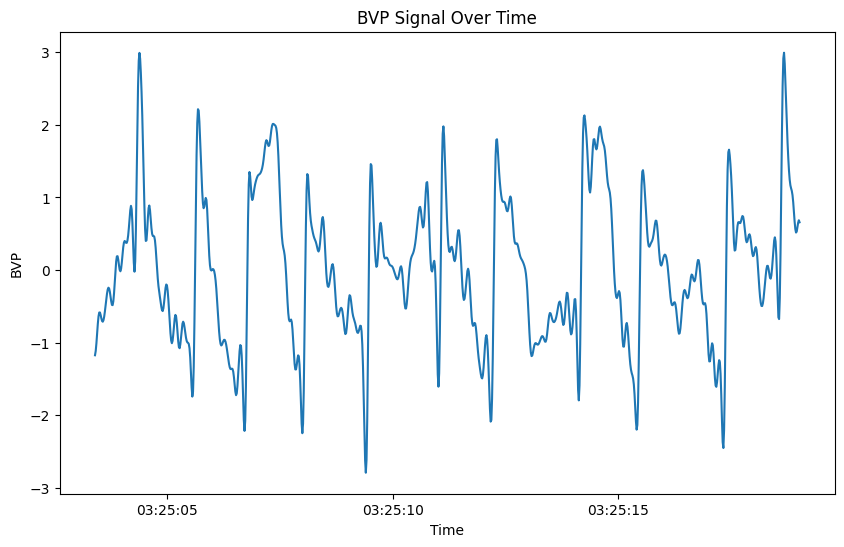

In [52]:
import matplotlib.pyplot as plt

# Plot BVP signal
plt.figure(figsize=(10, 6))
plt.plot(df['TIMESTAMP'], df['BVP'])
plt.title("BVP Signal Over Time")
plt.xlabel("Time")
plt.ylabel("BVP")
plt.show()


Sleep_Stage
R    1000
Name: count, dtype: int64


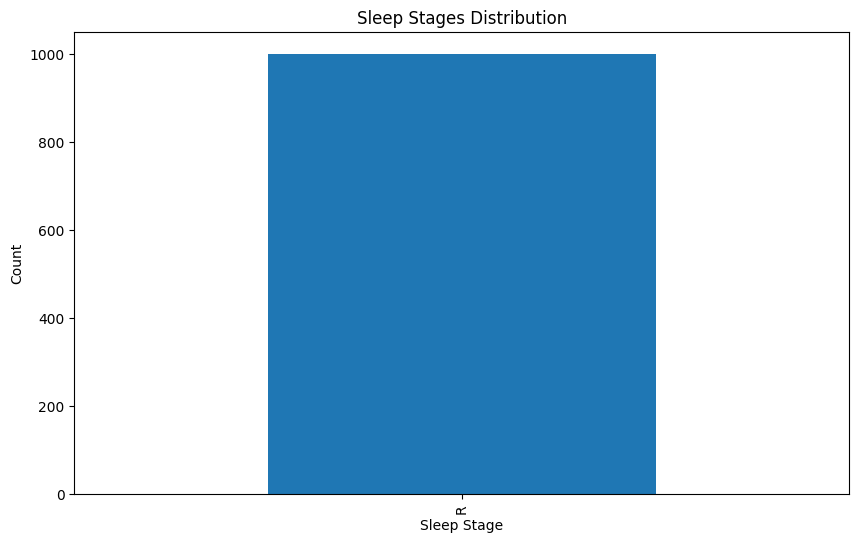

In [53]:
# Count the sleep stages
print(df['Sleep_Stage'].value_counts())

# Plot the distribution of sleep stages
df['Sleep_Stage'].value_counts().plot(kind='bar', figsize=(10, 6))
plt.title("Sleep Stages Distribution")
plt.xlabel("Sleep Stage")
plt.ylabel("Count")
plt.show()


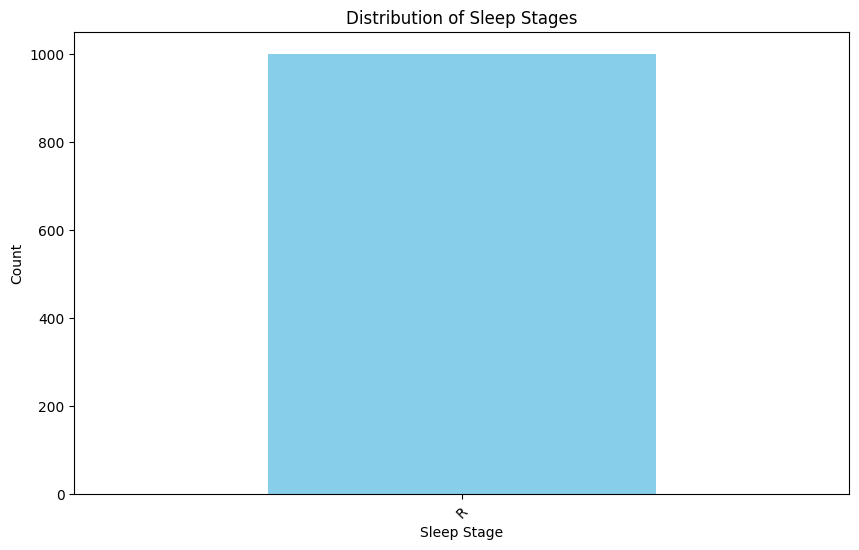

In [54]:
# Plot the distribution of sleep stages
plt.figure(figsize=(10, 6))
df['Sleep_Stage'].value_counts().plot(kind='bar', color='skyblue')
plt.title("Distribution of Sleep Stages")
plt.xlabel("Sleep Stage")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


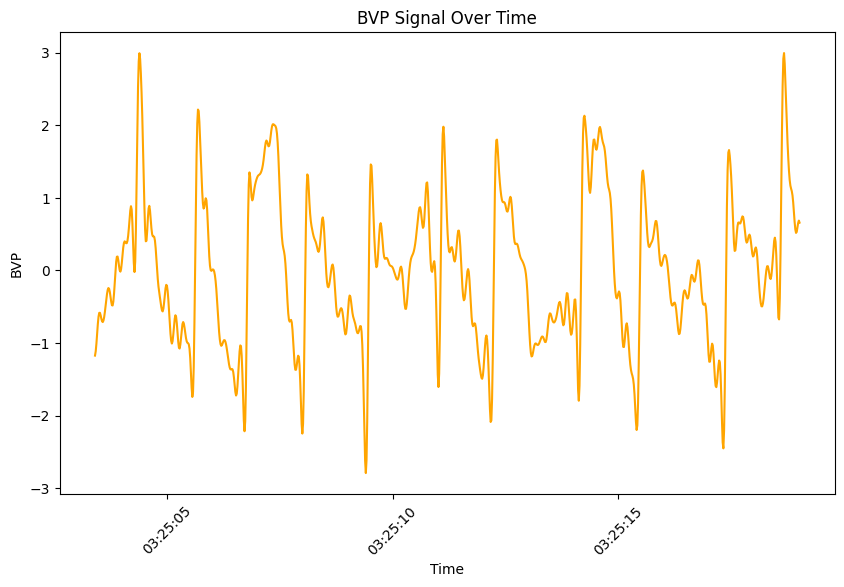

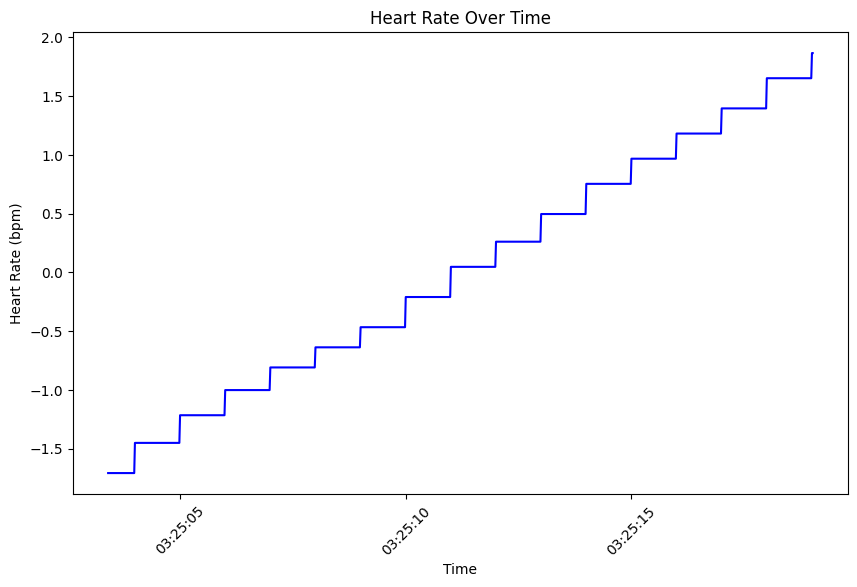

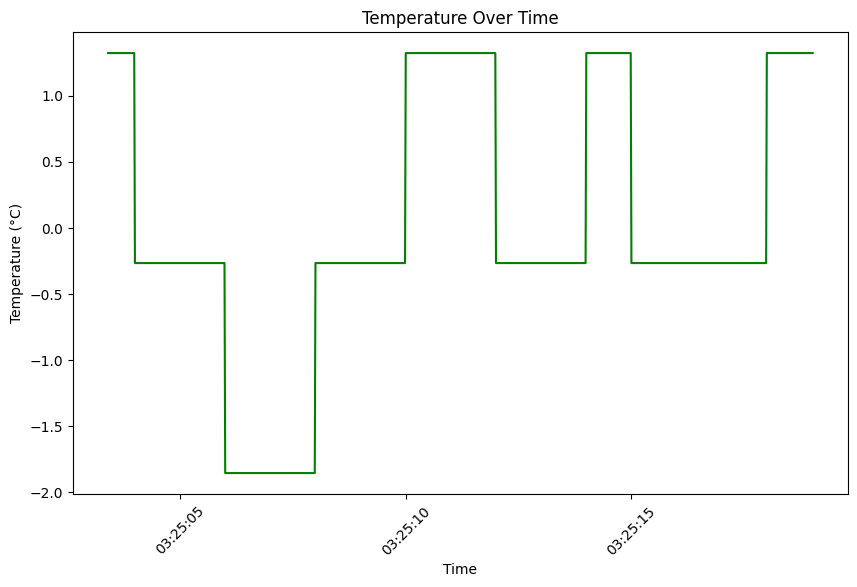

In [55]:
# Plot BVP signal over time
plt.figure(figsize=(10, 6))
plt.plot(df['TIMESTAMP'], df['BVP'], label="BVP", color='orange')
plt.title("BVP Signal Over Time")
plt.xlabel("Time")
plt.ylabel("BVP")
plt.xticks(rotation=45)
plt.show()

# Plot HR signal over time
plt.figure(figsize=(10, 6))
plt.plot(df['TIMESTAMP'], df['HR'], label="Heart Rate (HR)", color='blue')
plt.title("Heart Rate Over Time")
plt.xlabel("Time")
plt.ylabel("Heart Rate (bpm)")
plt.xticks(rotation=45)
plt.show()

# Plot TEMP signal over time
plt.figure(figsize=(10, 6))
plt.plot(df['TIMESTAMP'], df['TEMP'], label="Temperature", color='green')
plt.title("Temperature Over Time")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.xticks(rotation=45)
plt.show()


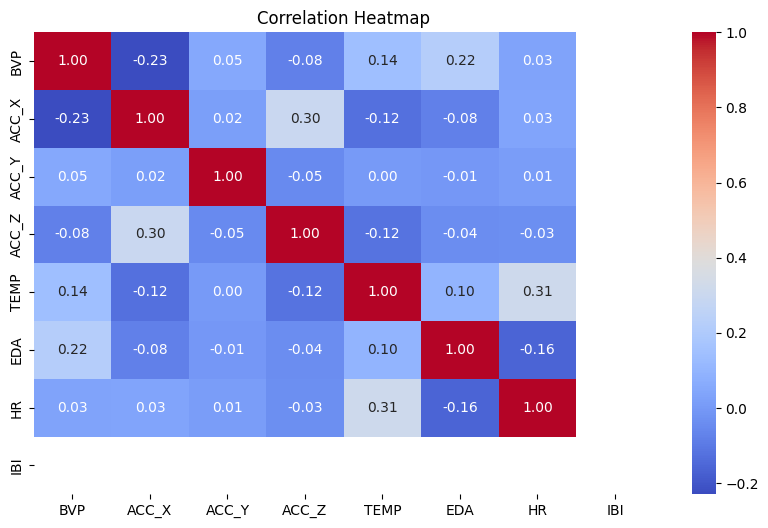

In [56]:
import seaborn as sns

# Select the relevant columns for correlation analysis
corr_columns = ['BVP', 'ACC_X', 'ACC_Y', 'ACC_Z', 'TEMP', 'EDA', 'HR', 'IBI']

# Calculate correlation matrix
corr_matrix = df[corr_columns].corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


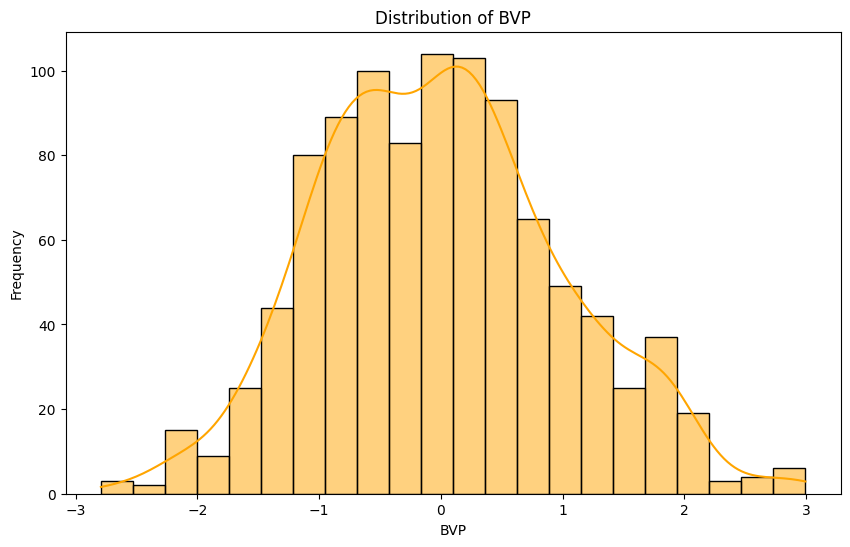

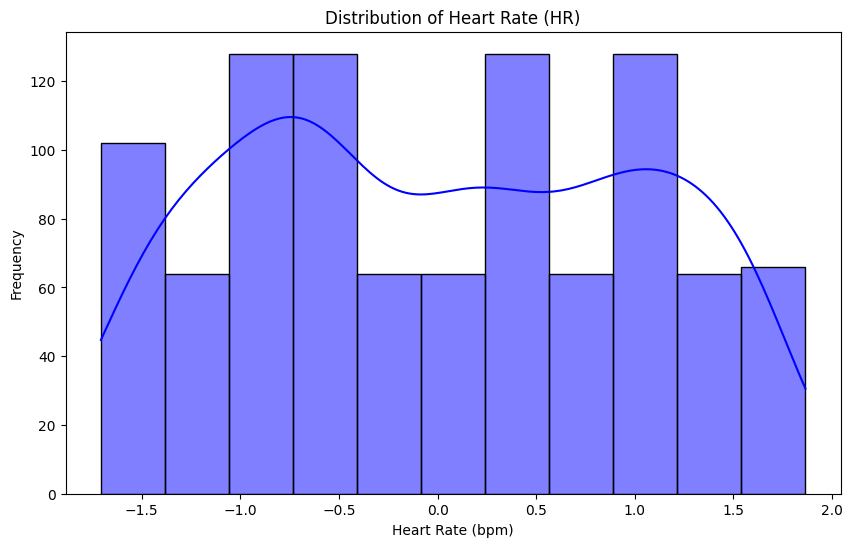

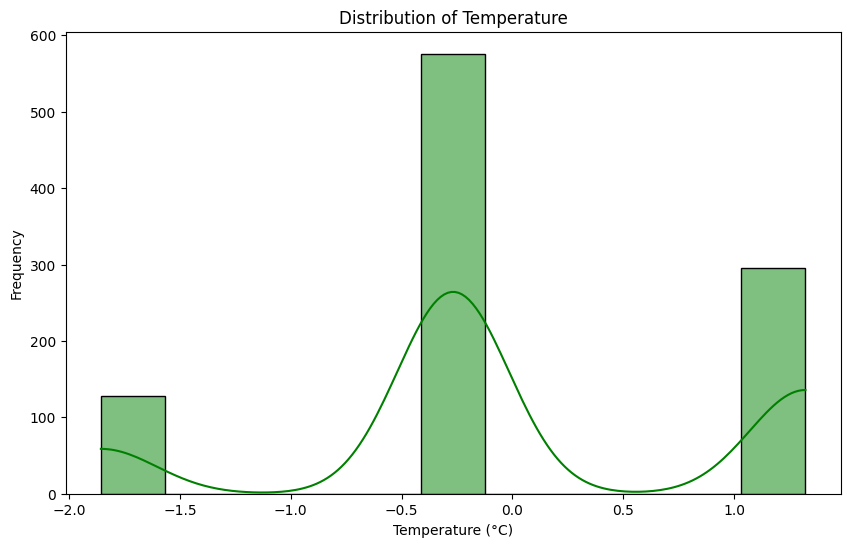

In [57]:
# Plot the distribution of BVP
plt.figure(figsize=(10, 6))
sns.histplot(df['BVP'], kde=True, color='orange')
plt.title("Distribution of BVP")
plt.xlabel("BVP")
plt.ylabel("Frequency")
plt.show()

# Plot the distribution of HR
plt.figure(figsize=(10, 6))
sns.histplot(df['HR'], kde=True, color='blue')
plt.title("Distribution of Heart Rate (HR)")
plt.xlabel("Heart Rate (bpm)")
plt.ylabel("Frequency")
plt.show()

# Plot the distribution of TEMP
plt.figure(figsize=(10, 6))
sns.histplot(df['TEMP'], kde=True, color='green')
plt.title("Distribution of Temperature")
plt.xlabel("Temperature (°C)")
plt.ylabel("Frequency")
plt.show()


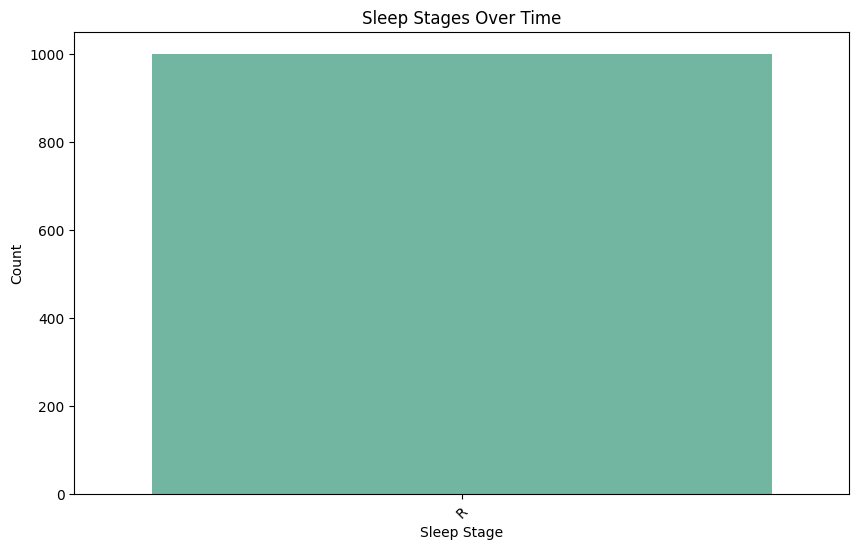

In [58]:
# Plot Sleep Stages Over Time
plt.figure(figsize=(10, 6))
sns.countplot(x='Sleep_Stage', data=df, palette="Set2")
plt.title("Sleep Stages Over Time")
plt.xlabel("Sleep Stage")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


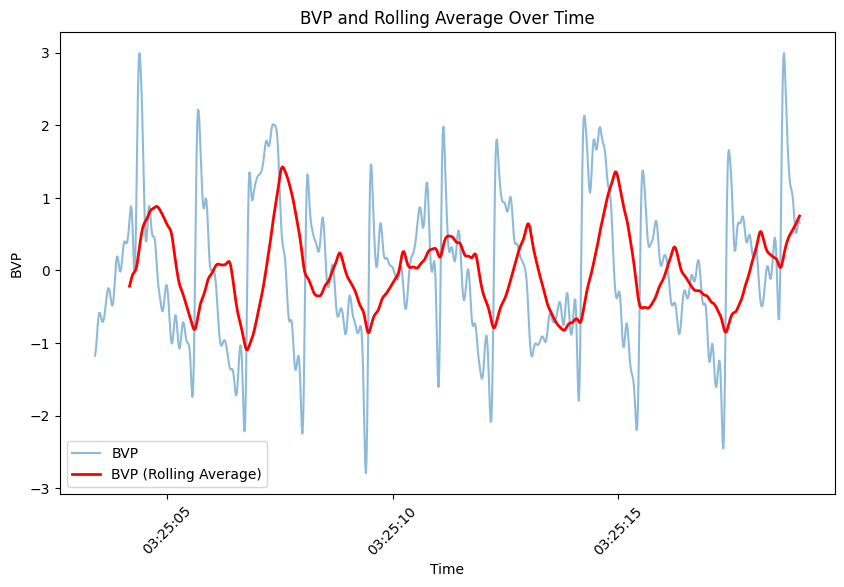

In [59]:
# Rolling average for BVP
df['BVP_MA'] = df['BVP'].rolling(window=50).mean()

# Plot BVP with its rolling average
plt.figure(figsize=(10, 6))
plt.plot(df['TIMESTAMP'], df['BVP'], label='BVP', alpha=0.5)
plt.plot(df['TIMESTAMP'], df['BVP_MA'], label='BVP (Rolling Average)', color='red', linewidth=2)
plt.title("BVP and Rolling Average Over Time")
plt.xlabel("Time")
plt.ylabel("BVP")
plt.legend()
plt.xticks(rotation=45)
plt.show()


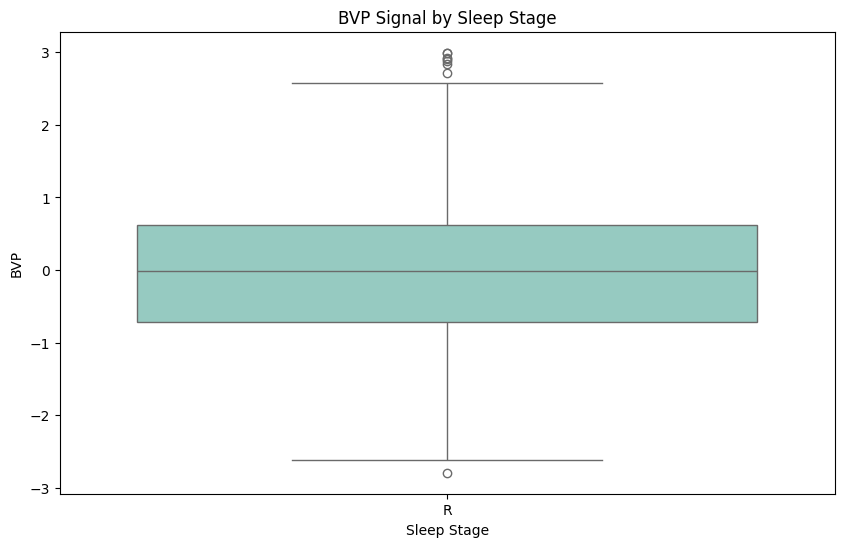

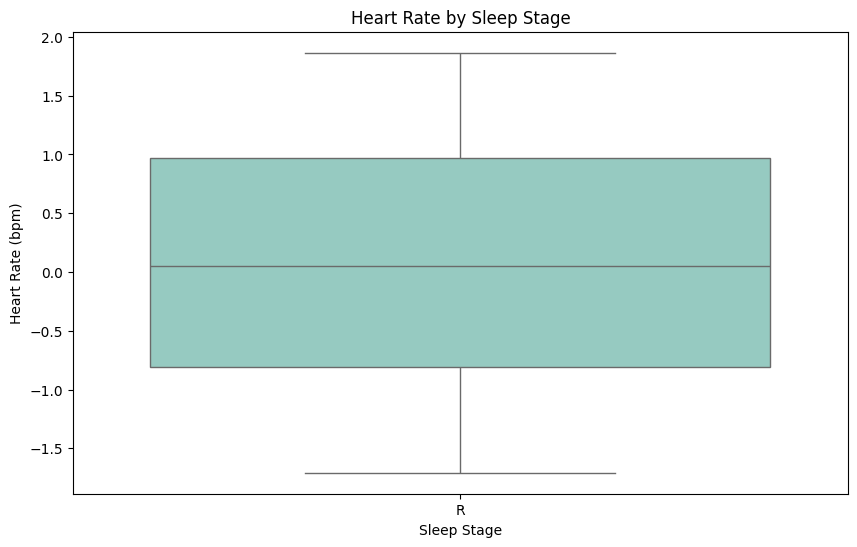

In [60]:
# Boxplot for BVP
plt.figure(figsize=(10, 6))
sns.boxplot(x='Sleep_Stage', y='BVP', data=df, palette="Set3")
plt.title("BVP Signal by Sleep Stage")
plt.xlabel("Sleep Stage")
plt.ylabel("BVP")
plt.show()

# Boxplot for HR
plt.figure(figsize=(10, 6))
sns.boxplot(x='Sleep_Stage', y='HR', data=df, palette="Set3")
plt.title("Heart Rate by Sleep Stage")
plt.xlabel("Sleep Stage")
plt.ylabel("Heart Rate (bpm)")
plt.show()


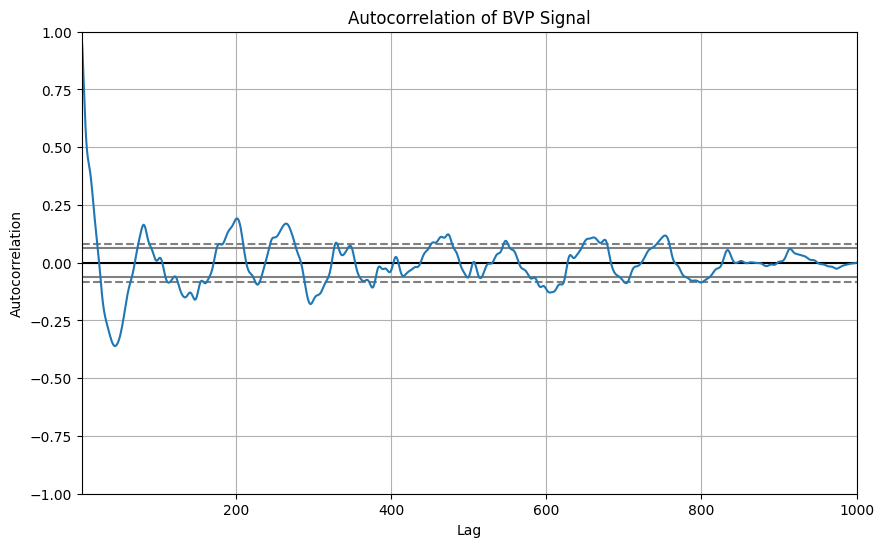

In [61]:
from pandas.plotting import autocorrelation_plot

# Autocorrelation plot for BVP signal
plt.figure(figsize=(10, 6))
autocorrelation_plot(df['BVP'])
plt.title("Autocorrelation of BVP Signal")
plt.show()


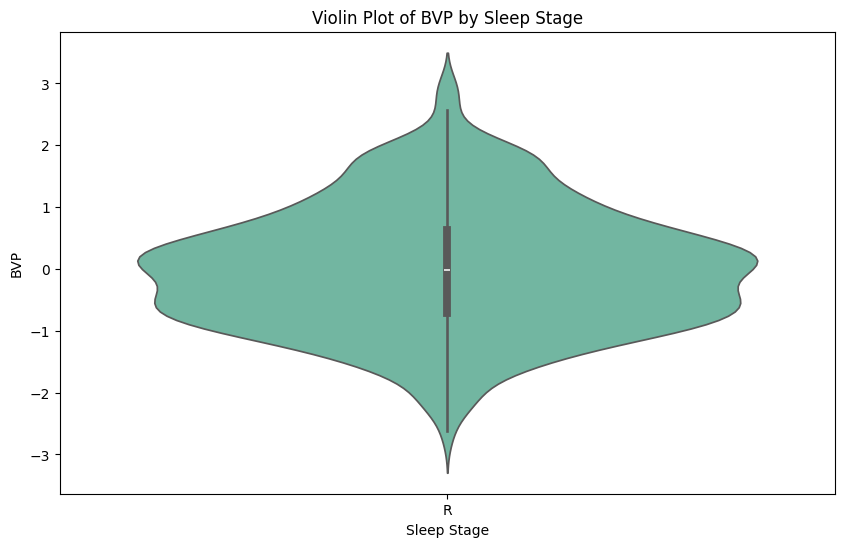

In [62]:
# Violin plot for BVP by Sleep Stage
plt.figure(figsize=(10, 6))
sns.violinplot(x='Sleep_Stage', y='BVP', data=df, palette="Set2")
plt.title("Violin Plot of BVP by Sleep Stage")
plt.xlabel("Sleep Stage")
plt.ylabel("BVP")
plt.show()


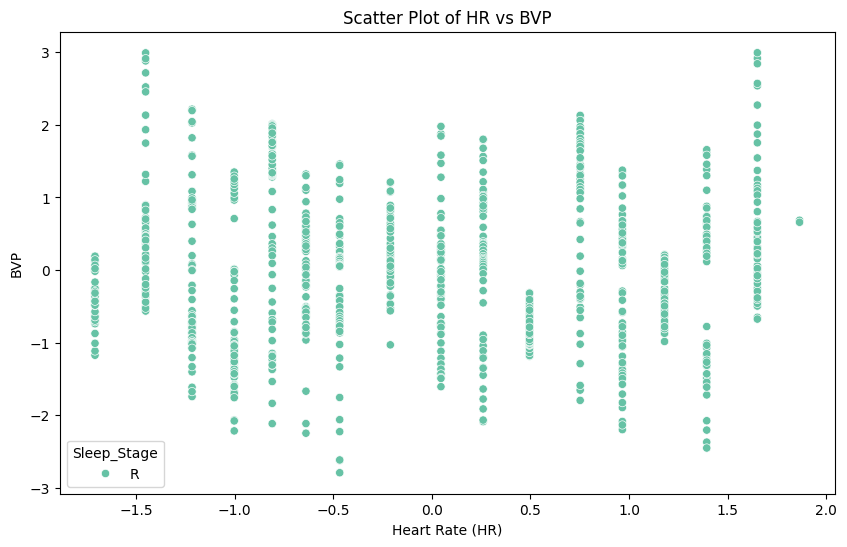

In [63]:
# Scatter plot for HR vs BVP
plt.figure(figsize=(10, 6))
sns.scatterplot(x='HR', y='BVP', data=df, hue='Sleep_Stage', palette="Set2")
plt.title("Scatter Plot of HR vs BVP")
plt.xlabel("Heart Rate (HR)")
plt.ylabel("BVP")
plt.show()



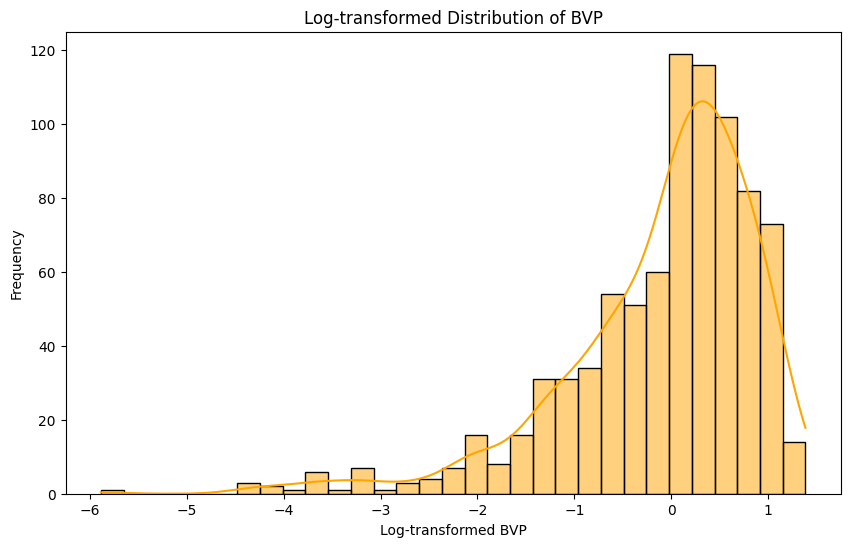

In [64]:
import numpy as np

# Apply log transformation to BVP (ensure values are positive)
df['BVP_log'] = np.log1p(df['BVP'])  # np.log1p is log(1 + x) to handle zero values
plt.figure(figsize=(10, 6))
sns.histplot(df['BVP_log'], kde=True, color='orange')
plt.title("Log-transformed Distribution of BVP")
plt.xlabel("Log-transformed BVP")
plt.ylabel("Frequency")
plt.show()


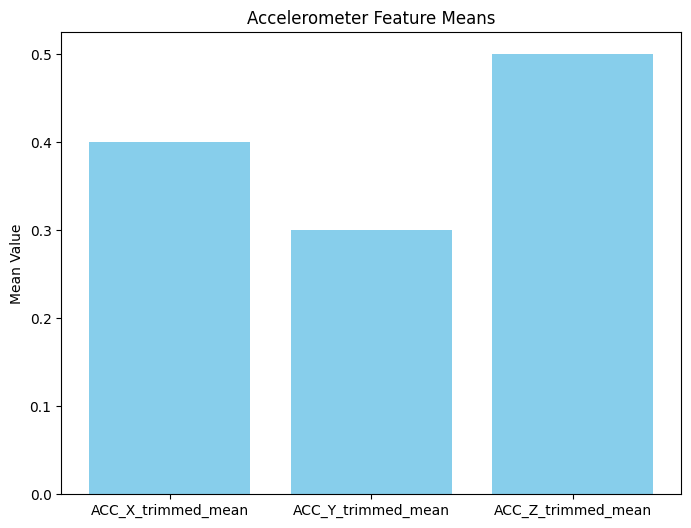

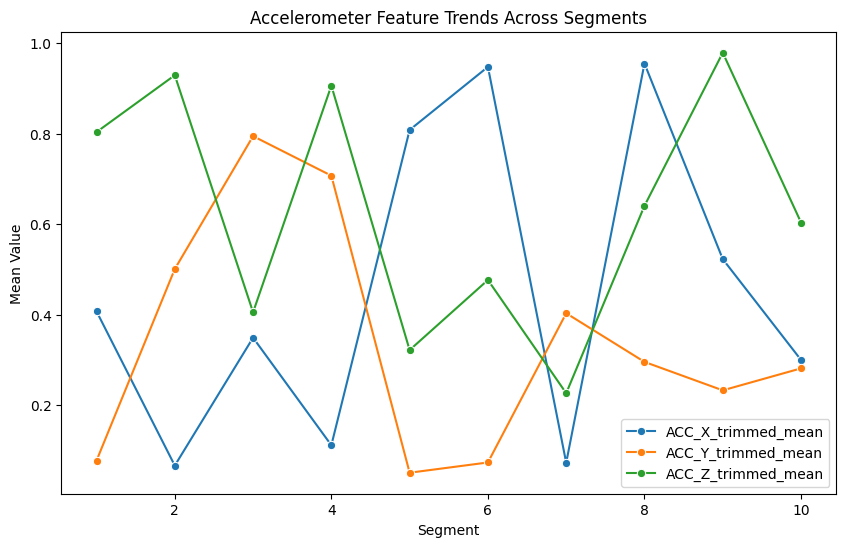

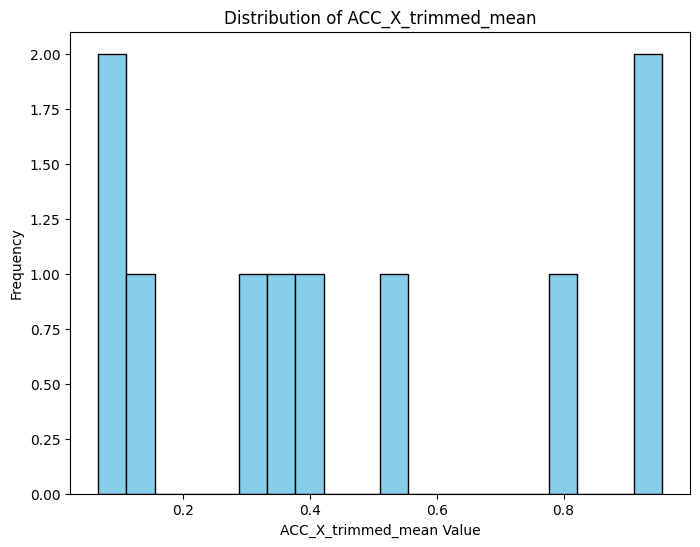

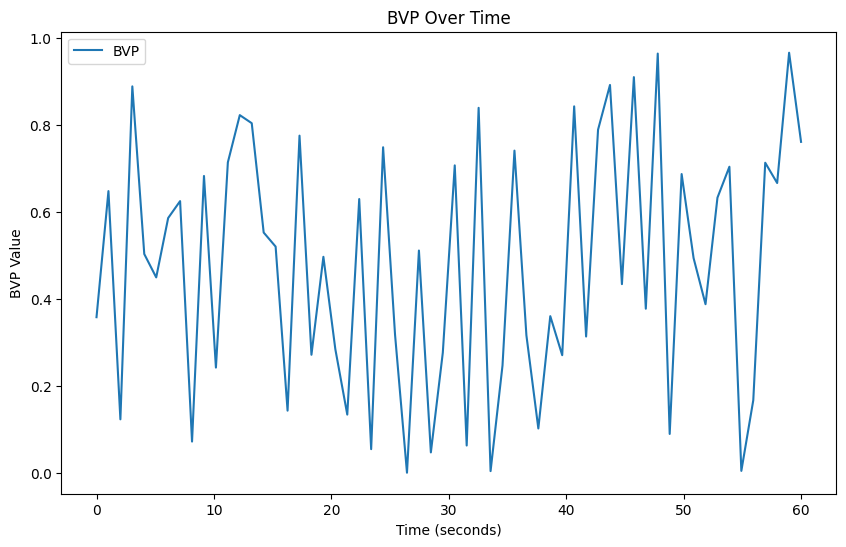

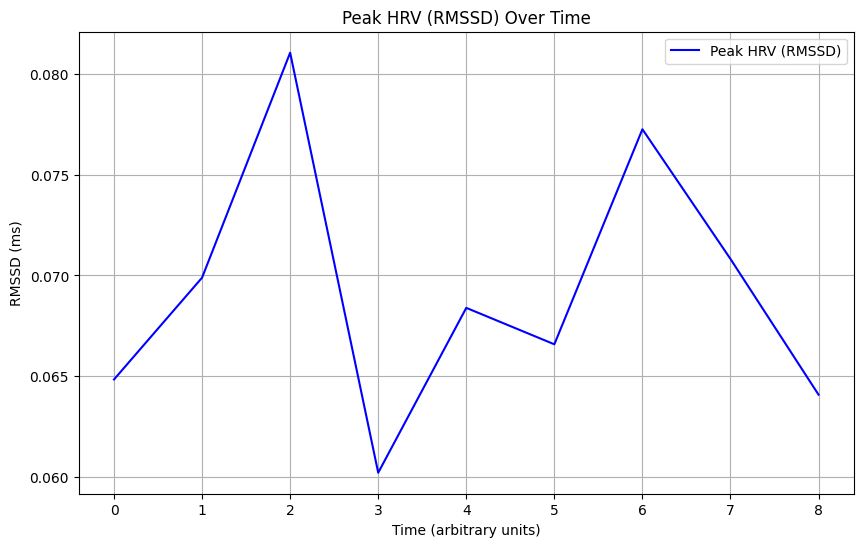

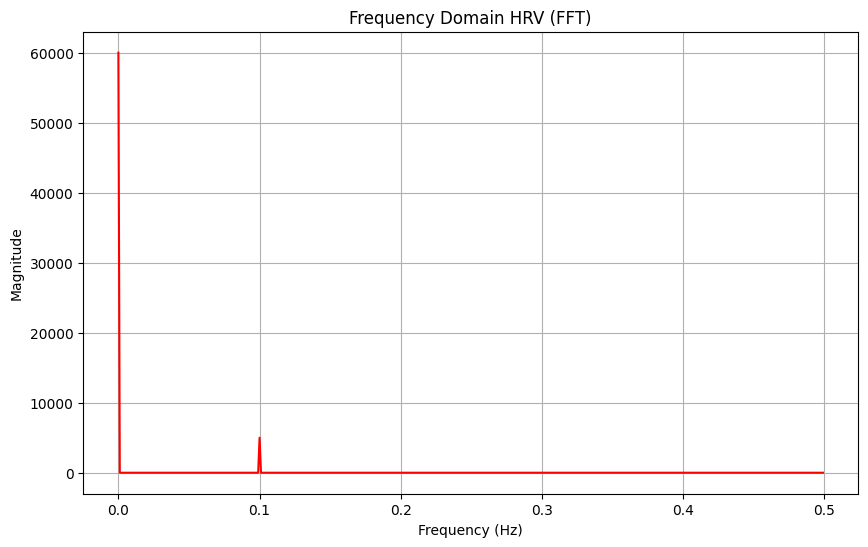

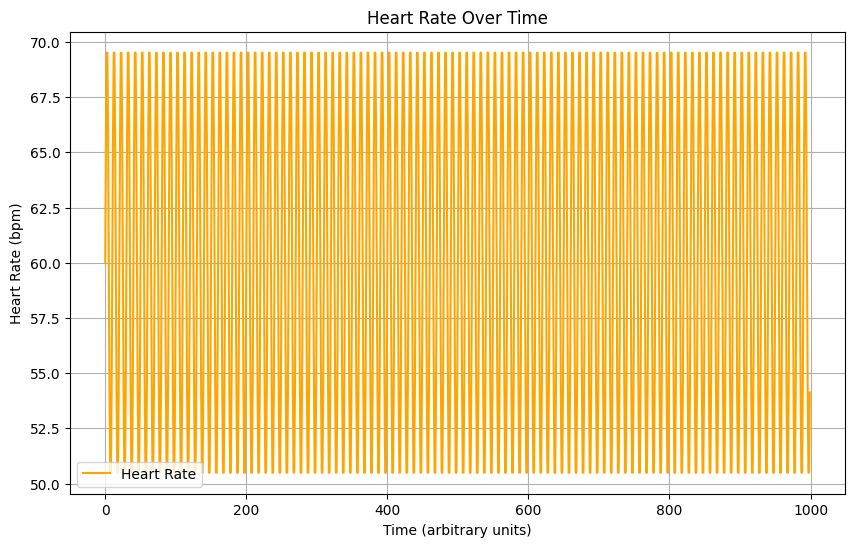

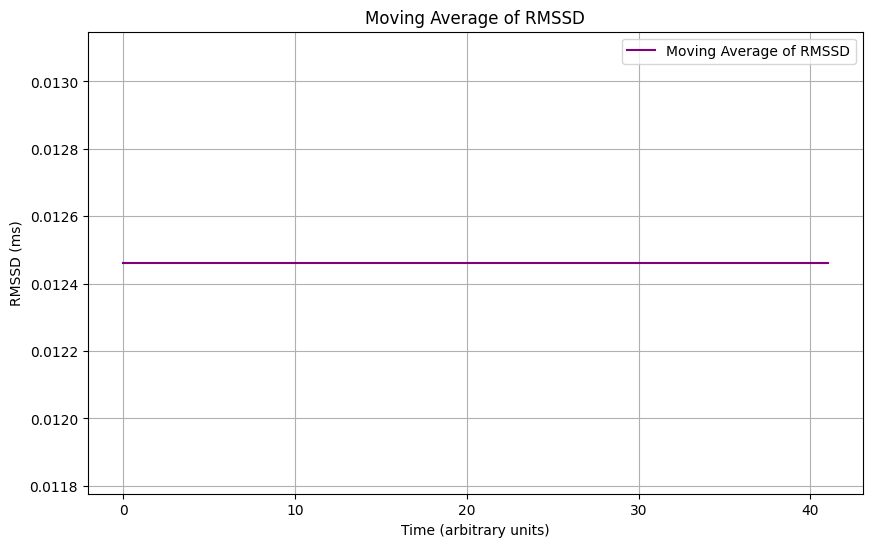

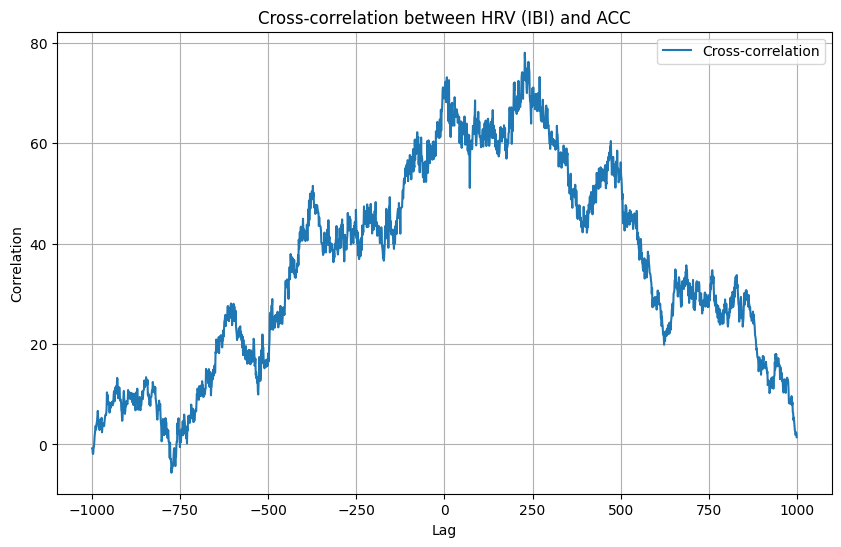

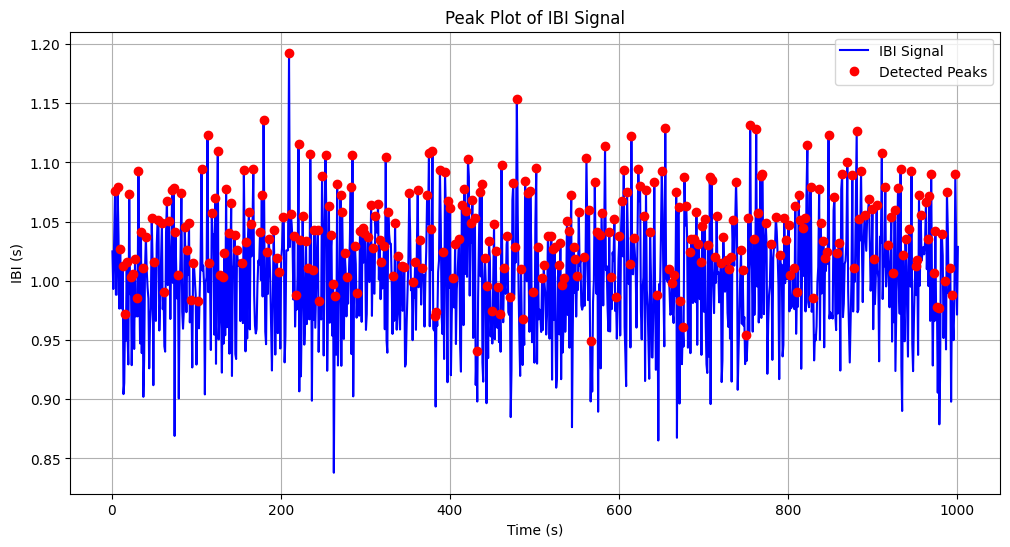

In [65]:
# Import necessary functions from the feature_engineering file
from ML_Dataset.DREAMT.feature_engineering import *
import matplotlib.pyplot as plt

def plot_acc_features(acc_features_dict):
    # Example of plotting ACC features: ACC_X_trimmed_mean, ACC_Y_trimmed_mean, etc.

    # Extract values from the dictionary
    acc_x_mean = acc_features_dict['ACC_X_trimmed_mean']
    acc_y_mean = acc_features_dict['ACC_Y_trimmed_mean']
    acc_z_mean = acc_features_dict['ACC_Z_trimmed_mean']

    # Create a list of feature names and their corresponding values
    feature_names = ['ACC_X_trimmed_mean', 'ACC_Y_trimmed_mean', 'ACC_Z_trimmed_mean']
    feature_values = [acc_x_mean, acc_y_mean, acc_z_mean]

    # Plotting the features
    plt.figure(figsize=(8, 6))
    plt.bar(feature_names, feature_values, color='skyblue')
    plt.title('Accelerometer Feature Means')
    plt.ylabel('Mean Value')
    plt.show()

# Example usage
acc_features_dict = {
    "ACC_X_trimmed_mean": 0.4,
    "ACC_Y_trimmed_mean": 0.3,
    "ACC_Z_trimmed_mean": 0.5,
}
plot_acc_features(acc_features_dict)


def plot_features_for_multiple_segments(df):
    # Assuming df has columns like ACC_X_trimmed_mean, ACC_Y_trimmed_mean, etc.
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x='Segment', y='ACC_X_trimmed_mean', label='ACC_X_trimmed_mean', marker='o')
    sns.lineplot(data=df, x='Segment', y='ACC_Y_trimmed_mean', label='ACC_Y_trimmed_mean', marker='o')
    sns.lineplot(data=df, x='Segment', y='ACC_Z_trimmed_mean', label='ACC_Z_trimmed_mean', marker='o')

    plt.title('Accelerometer Feature Trends Across Segments')
    plt.xlabel('Segment')
    plt.ylabel('Mean Value')
    plt.legend()
    plt.show()

# Example usage:
segments_data = {
    "Segment": np.arange(1, 11),
    "ACC_X_trimmed_mean": np.random.random(10),
    "ACC_Y_trimmed_mean": np.random.random(10),
    "ACC_Z_trimmed_mean": np.random.random(10)
}
df_segments = pd.DataFrame(segments_data)
plot_features_for_multiple_segments(df_segments)

def plot_histogram_for_feature(feature_data, feature_name):
    plt.figure(figsize=(8, 6))
    plt.hist(feature_data, bins=20, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {feature_name}')
    plt.xlabel(f'{feature_name} Value')
    plt.ylabel('Frequency')
    plt.show()

# Example usage:
plot_histogram_for_feature(df_segments['ACC_X_trimmed_mean'], 'ACC_X_trimmed_mean')

def plot_time_series_data(time_data, signal_data, signal_name):
    plt.figure(figsize=(10, 6))
    plt.plot(time_data, signal_data, label=signal_name)
    plt.title(f'{signal_name} Over Time')
    plt.xlabel('Time (seconds)')
    plt.ylabel(f'{signal_name} Value')
    plt.legend()
    plt.show()

# Example usage:
time_data = np.linspace(0, 60, 60)  # time from 0 to 60 seconds
signal_data = np.random.random(60)  # random signal data
plot_time_series_data(time_data, signal_data, 'BVP')


import numpy as np
import matplotlib.pyplot as plt

# Function to compute RMSSD (time-domain HRV)
def compute_rmssd(ibi):
    # Compute successive differences
    diff = np.diff(ibi)

    # Compute squared differences
    squared_diff = np.square(diff)

    # RMSSD is the square root of the mean squared differences
    rmssd = np.sqrt(np.mean(squared_diff))
    return rmssd

# Simulate some IBI data (interbeat interval in seconds)
np.random.seed(42)
ibi_data = np.random.normal(1, 0.05, 1000)  # Simulated IBI data (in seconds)

# Compute HRV (RMSSD) over time windows (e.g., using a sliding window approach)
window_size = 100  # Window size in samples (100 IBIs)
rmssd_values = []

for i in range(0, len(ibi_data) - window_size, window_size):
    window_ibi = ibi_data[i:i + window_size]
    rmssd = compute_rmssd(window_ibi)
    rmssd_values.append(rmssd)

# Create time vector for plotting (based on the window size and number of windows)
time = np.arange(0, len(rmssd_values))

# Plot the Peak HRV (RMSSD values)
plt.figure(figsize=(10, 6))
plt.plot(time, rmssd_values, label='Peak HRV (RMSSD)', color='b')
plt.title('Peak HRV (RMSSD) Over Time')
plt.xlabel('Time (arbitrary units)')
plt.ylabel('RMSSD (ms)')
plt.grid(True)
plt.legend()
plt.show()

from scipy.fft import fft

# Simulate HR data (e.g., heart rate data)
hr_data = 60 + 10 * np.sin(2 * np.pi * 0.1 * np.arange(1000))  # Simulated HR data

# Perform FFT to get the frequency domain representation
N = len(hr_data)
frequencies = np.fft.fftfreq(N, d=1)  # Frequency axis (assuming 1 sample per second)
fft_values = np.abs(fft(hr_data))  # Magnitude of FFT

# Plot the Frequency Domain HRV (FFT)
plt.figure(figsize=(10, 6))
plt.plot(frequencies[:N//2], fft_values[:N//2], color='r')
plt.title('Frequency Domain HRV (FFT)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)
plt.show()

# Plot Heart Rate (HR) over time
hr_data = 60 + 10 * np.sin(2 * np.pi * 0.1 * np.arange(1000))  # Simulated HR data

plt.figure(figsize=(10, 6))
plt.plot(hr_data, label='Heart Rate', color='orange')
plt.title('Heart Rate Over Time')
plt.xlabel('Time (arbitrary units)')
plt.ylabel('Heart Rate (bpm)')
plt.grid(True)
plt.legend()
plt.show()

# Apply moving average to RMSSD values
window_size = 50
moving_avg_rmssd = np.convolve(rmssd_values, np.ones(window_size) / window_size, mode='valid')

# Plot moving average of RMSSD
plt.figure(figsize=(10, 6))
plt.plot(moving_avg_rmssd, color='purple', label='Moving Average of RMSSD')
plt.title('Moving Average of RMSSD')
plt.xlabel('Time (arbitrary units)')
plt.ylabel('RMSSD (ms)')
plt.grid(True)
plt.legend()
plt.show()

# Cross-correlation between HRV (IBI) and ACC (simulated signal)
from numpy import correlate

acc_data = np.random.normal(0, 1, len(ibi_data))  # Simulating ACC signal for example

# Cross-correlation between HRV (IBI) and ACC
cross_corr = correlate(ibi_data, acc_data, mode='full')
lags = np.arange(-len(ibi_data) + 1, len(ibi_data))

plt.figure(figsize=(10, 6))
plt.plot(lags, cross_corr, label='Cross-correlation')
plt.title('Cross-correlation between HRV (IBI) and ACC')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.grid(True)
plt.legend()
plt.show()

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Assuming you have `ibi_data` (in seconds or milliseconds)
ibi_data = np.array(ibi_data)  # ensure it's a NumPy array

# Optional: create time axis if you don't already have one
time_ibi = np.cumsum(ibi_data)  # simulate time based on cumulative IBI

# Find peaks
peaks, _ = find_peaks(ibi_data, distance=1, prominence=0.01)

# Plotting the IBI signal with peaks
plt.figure(figsize=(12, 6))
plt.plot(time_ibi, ibi_data, label='IBI Signal', color='blue')
plt.plot(time_ibi[peaks], ibi_data[peaks], 'ro', label='Detected Peaks')
plt.title('Peak Plot of IBI Signal')
plt.xlabel('Time (s)')
plt.ylabel('IBI (s)')
plt.legend()
plt.grid(True)
plt.show()


FEATURE ENGINEERING

In [66]:
from scipy.fft import fft
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="threadpoolctl")



label_encoder = LabelEncoder()
df['Sleep_Stage_encoded'] = label_encoder.fit_transform(df['Sleep_Stage'])


# Apply FFT to BVP signal to capture frequency domain features
bvp_fft = fft(df['BVP'])
df['BVP_freq'] = np.abs(bvp_fft)
# Calculate rolling mean and standard deviation for HR over a 5-minute window (or 5 samples)
df['HR_rolling_mean'] = df['HR'].rolling(window=5).mean()
df['HR_rolling_std'] = df['HR'].rolling(window=5).std()




In [67]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['Sleep_Stage_encoded'] = label_encoder.fit_transform(df['Sleep_Stage'])


X = df.drop(['Sleep_Stage', 'Sleep_Stage_encoded'], axis=1)  # Features
y = df['Sleep_Stage_encoded']  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [68]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Define the directory containing participant data files
data_dir = "./ML_Dataset/DREAMT/dataset_sample/E4_aggregate_subsample/"

# List all CSV files (assuming participant data files have a specific naming pattern, e.g., subsampled_S039_whole_df.csv)
files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]

# Initialize a list to store the models and results for each participant
results = []

# Iterate through each participant's file
for file in files:
    # Load data for the participant
    data_path = os.path.join(data_dir, file)
    df = pd.read_csv(data_path)

    # Preprocess the data (make sure you follow your earlier steps here)
    # Example: Normalize features
    from sklearn.preprocessing import StandardScaler

    # Normalize continuous features
    scaler = StandardScaler()
    df[['BVP', 'ACC_X', 'ACC_Y', 'ACC_Z', 'TEMP', 'EDA', 'HR', 'IBI']] = scaler.fit_transform(
        df[['BVP', 'ACC_X', 'ACC_Y', 'ACC_Z', 'TEMP', 'EDA', 'HR', 'IBI']])

    # Encode the target variable 'Sleep_Stage' (if needed)
    from sklearn.preprocessing import LabelEncoder
    label_encoder = LabelEncoder()
    df['Sleep_Stage_encoded'] = label_encoder.fit_transform(df['Sleep_Stage'])

    # Define features (X) and target (y)
    X = df.drop(['Sleep_Stage', 'Sleep_Stage_encoded'], axis=1)
    y = df['Sleep_Stage_encoded']


In [69]:
!pip install gpboost


In [70]:
!pip install imbalanced-learn

In [71]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
import glob

# 1. Load DREAMT Training Data
train_files = glob.glob('ML_Dataset/DREAMT/dataset_sample/E4_aggregate_subsample/*.csv')
train_df = pd.concat([pd.read_csv(file) for file in train_files], ignore_index=True)
print(train_df.columns)

# 2. Load Your Test Data
test_files = glob.glob('ML_Dataset/testdata/E4_aggregate/*.csv')
test_df = pd.concat([pd.read_csv(file) for file in test_files], ignore_index=True)

# 3. Drop NaNs and fill missing event labels
for df in [train_df, test_df]:
    df['TIMESTAMP'] = df['TIMESTAMP'].ffill()
    df['Sleep_Stage'] = df['Sleep_Stage'].fillna('Unknown')
    df['Obstructive_Apnea'] = df['Obstructive_Apnea'].fillna(0)
    df['Central_Apnea'] = df['Central_Apnea'].fillna(0)
    df['Hypopnea'] = df['Hypopnea'].fillna(0)
    df['Multiple_Events'] = df['Multiple_Events'].fillna(0)

    numeric_cols = ['BVP', 'ACC_X', 'ACC_Y', 'ACC_Z', 'TEMP', 'EDA', 'HR', 'IBI']
    for col in numeric_cols:
        df[col] = df[col].fillna(0)

# 4. Encode Target Labels (e.g., Sleep Stage)
label_encoder = LabelEncoder()
train_df['Sleep_Stage'] = label_encoder.fit_transform(train_df['Sleep_Stage'])
test_df['Sleep_Stage'] = label_encoder.transform(test_df['Sleep_Stage'])

# 5. Feature Columns
features = ['BVP', 'ACC_X', 'ACC_Y', 'ACC_Z', 'TEMP', 'EDA', 'HR', 'IBI']
X_train = train_df[features]
y_train = train_df['Sleep_Stage']
X_test = test_df[features]
y_test = test_df['Sleep_Stage']

# 6. Handle Class Imbalance using SMOTE (Optional)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# 7. LightGBM Model Training
# Create the dataset for LightGBM
train_data = lgb.Dataset(X_train_smote, label=y_train_smote)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Set parameters for LightGBM
params = {
    'objective': 'multiclass',
    'num_class': len(label_encoder.classes_),  # Number of unique classes in Sleep_Stage
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'is_unbalance': True,
    'feature_fraction': 0.9
}

# Define early stopping callback
early_stopping = lgb.early_stopping(stopping_rounds=100)

# Train the model with early stopping
clf = lgb.train(params,
                train_data,
                valid_sets=[test_data],
                num_boost_round=1000,
                callbacks=[early_stopping])

# 8. Predictions and Evaluation
y_pred = clf.predict(X_test, num_iteration=clf.best_iteration)
y_pred_labels = np.argmax(y_pred, axis=1)

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred_labels))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_labels))


Index(['TIMESTAMP', 'BVP', 'ACC_X', 'ACC_Y', 'ACC_Z', 'TEMP', 'EDA', 'HR',
       'IBI', 'Sleep_Stage', 'Obstructive_Apnea', 'Central_Apnea', 'Hypopnea',
       'Multiple_Events'],
      dtype='object')
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052749 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2027
[LightGBM] [Info] Number of data points in the train set: 245226, number of used features: 8
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 1.78702
Classification Report:
               precision   

In [72]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
import glob

# 1. Load DREAMT Training Data
train_files = glob.glob('ML_Dataset/DREAMT/dataset_sample/E4_aggregate_subsample/*.csv')
train_df = pd.concat([pd.read_csv(file) for file in train_files], ignore_index=True)
print(train_df.columns)

# 2. Load Your Test Data
test_files = glob.glob('ML_Dataset/testdata/E4_aggregate/*.csv')
test_df = pd.concat([pd.read_csv(file) for file in test_files], ignore_index=True)

# 3. Drop NaNs and fill missing event labels

for df in [train_df, test_df]:
    df['TIMESTAMP'] = df['TIMESTAMP'].ffill()
    df['Sleep_Stage'] = df['Sleep_Stage'].fillna('Unknown')
    df['Obstructive_Apnea'] = df['Obstructive_Apnea'].fillna(0)
    df['Central_Apnea'] = df['Central_Apnea'].fillna(0)
    df['Hypopnea'] = df['Hypopnea'].fillna(0)
    df['Multiple_Events'] = df['Multiple_Events'].fillna(0)

    numeric_cols = ['BVP', 'ACC_X', 'ACC_Y', 'ACC_Z', 'TEMP', 'EDA', 'HR', 'IBI']
    for col in numeric_cols:
        df[col] = df[col].fillna(0)



# 4. Encode Target Labels (e.g., Sleep Stage)
label_encoder = LabelEncoder()
train_df['Sleep_Stage'] = label_encoder.fit_transform(train_df['Sleep_Stage'])
test_df['Sleep_Stage'] = label_encoder.transform(test_df['Sleep_Stage'])

# 5. Feature Columns
features = ['BVP', 'ACC_X', 'ACC_Y', 'ACC_Z', 'TEMP', 'EDA', 'HR', 'IBI']
X_train = train_df[features]
y_train = train_df['Sleep_Stage']
X_test = test_df[features]
y_test = test_df['Sleep_Stage']
# SMOTE to balance the dataset
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_bal)
X_test_scaled = scaler.transform(X_test)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced_subsample')
rf_model.fit(X_train_scaled, y_train_bal)

y_pred = rf_model.predict(X_test_scaled)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Index(['TIMESTAMP', 'BVP', 'ACC_X', 'ACC_Y', 'ACC_Z', 'TEMP', 'EDA', 'HR',
       'IBI', 'Sleep_Stage', 'Obstructive_Apnea', 'Central_Apnea', 'Hypopnea',
       'Multiple_Events'],
      dtype='object')
Confusion Matrix:
[[1000    0    0    0    0    0]
 [   0 1000    0    0    0    0]
 [   3  246    0  543    2  206]
 [   9 3255    2  258   29 1519]
 [  25 8955    7  990 1115 6436]
 [   0    0    0    0    0 1000]]

Classification Report:
              precision    recall  f1-score   support

          N1       0.96      1.00      0.98      1000
          N2       0.07      1.00      0.14      1000
          N3       0.00      0.00      0.00      1000
           P       0.14      0.05      0.08      5072
           R       0.97      0.06      0.12     17528
           W       0.11      1.00      0.20      1000

    accuracy                           0.16     26600
   macro avg       0.38      0.52      0.25     26600
weighted avg       0.71      0.16      0.14     26600

